<a href="https://colab.research.google.com/github/RezSat/synthetic-data-generator/blob/main/train_layout_and_try_ocr_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/RezSat/synthetic-data-generator.git

Cloning into 'synthetic-data-generator'...
remote: Enumerating objects: 160, done.
remote: Counting objects: 100% (160/160), done.
remote: Compressing objects: 100% (107/107), done.
remote: Total 160 (delta 75), reused 132 (delta 52), pack-reused 0 (from 0)
Receiving objects: 100% (160/160), 2.27 MiB | 7.38 MiB/s, done.
Resolving deltas: 100% (75/75), done.


In [2]:
# 1. Update package list
!sudo apt-get update

# 2. Install Python dependencies
!pip install playwright nest_asyncio

# 3. Install the Browsers (The part that fails on Colab)
!playwright install
!playwright install-deps

Get:1 https://cli.github.com/packages stable InRelease [3,917 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:4 https://cli.github.com/packages stable/main amd64 Packages [345 B]
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,233 kB]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:7 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:8 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [9,592 kB]
Get:10 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:11 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:12 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:13 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu j

In [3]:
%cd synthetic-data-generator

/content/synthetic-data-generator


In [4]:
!python frankensteinv2.py --count 1000

Generated: complex_sample_0000 (Labels: 18)
Generated: complex_sample_0001 (Labels: 18)
Generated: complex_sample_0002 (Labels: 15)
Generated: complex_sample_0003 (Labels: 10)
Generated: complex_sample_0004 (Labels: 18)
Generated: complex_sample_0005 (Labels: 8)
Generated: complex_sample_0006 (Labels: 14)
Generated: complex_sample_0007 (Labels: 18)
Generated: complex_sample_0008 (Labels: 14)
Generated: complex_sample_0009 (Labels: 12)
Generated: complex_sample_0010 (Labels: 16)
Generated: complex_sample_0011 (Labels: 14)
Generated: complex_sample_0012 (Labels: 14)
Generated: complex_sample_0013 (Labels: 17)
Generated: complex_sample_0014 (Labels: 18)
Generated: complex_sample_0015 (Labels: 12)
Generated: complex_sample_0016 (Labels: 16)
Generated: complex_sample_0017 (Labels: 16)
Generated: complex_sample_0018 (Labels: 13)
Generated: complex_sample_0019 (Labels: 16)
Generated: complex_sample_0020 (Labels: 10)
Generated: complex_sample_0021 (Labels: 11)
Generated: complex_sample_0022 (L

# Data Processing

1.   Read your raw folder.
2.   Convert all coordinates to the LayoutLMv3 standard.
3.   Split the data: 80% Training (800 images) / 20% Testing (200 images).

4.   Save it as a HuggingFace Dataset that is ready for training.

In [5]:
import json
import os
from pathlib import Path
from PIL import Image
from datasets import Dataset, Features, Sequence, ClassLabel, Value, Array2D, Array3D

DATA_DIR = Path("dataset_complex")
IMAGES_DIR = DATA_DIR / "images"
LABELS_DIR = DATA_DIR / "labels"

# Class Map (must match to the Generator!)
# Assign a unique ID to each label type.
id2label = {
    0: "header",
    1: "text_block",
    2: "key_value",# Input fields
    3: "checkbox_group",
    4: "table",
    5: "signature_area"
}
label2id = {v: k for k, v in id2label.items()}

def normalize_bbox(bbox, width, height):
    """
    Convert [x, y, w, h] (pixels) -> [x1, y1, x2, y2] (0-1000 scale)
    LayoutLMv3 expects coordinates in the 0-1000 range.
    """
    x, y, w, h = bbox
    x1 = int((x / width) * 1000)
    y1 = int((y / height) * 1000)
    x2 = int(((x + w) / width) * 1000)
    y2 = int(((y + h) / height) * 1000)

    # Clip to ensure we don't exceed 1000
    return [
        max(0, min(x1, 1000)),
        max(0, min(y1, 1000)),
        max(0, min(x2, 1000)),
        max(0, min(y2, 1000))
    ]

def load_data():
    data_dicts = []

    # List all JSON files
    json_files = sorted(list(LABELS_DIR.glob("*.json")))
    print(f"Found {len(json_files)} samples.")

    for json_path in json_files:
        with open(json_path, "r", encoding="utf-8") as f:
            content = json.load(f)

        image_path = IMAGES_DIR / content["file"]
        if not image_path.exists():
            continue

        # Load image to verify dimensions
        with Image.open(image_path) as img:
            width, height = img.size

        # Process Bounding Boxes
        objects = {"id": [], "bbox": [], "category": []}

        for item in content["annotations"]:
            cls_name = item["class"]

            # Map "paragraph" -> "text_block" if naming varies
            if cls_name == "paragraph": cls_name = "text_block"
            if cls_name == "input": cls_name = "key_value"
            if cls_name == "checkbox_group": cls_name = "checkbox_group"

            if cls_name not in label2id:
                continue # Skip unknown classes

            # Convert bbox
            norm_box = normalize_bbox(item["bbox_px"], width, height)

            objects["id"].append(item["id"])
            objects["bbox"].append(norm_box)
            objects["category"].append(label2id[cls_name])

        data_dicts.append({
            "id": str(json_path.stem),
            "image_path": str(image_path),
            "bboxes": objects["bbox"],
            "ner_tags": objects["category"]
        })

    return data_dicts

print("Processing data...")
raw_data = load_data()

# Convert to HuggingFace Dataset
# Use a generator to load images on the fly (saves RAM)
def gen():
    for ex in raw_data:
        yield {
            "id": ex["id"],
            "image": Image.open(ex["image_path"]).convert("RGB"),
            "bboxes": ex["bboxes"],
            "ner_tags": ex["ner_tags"]
        }

# Define the features (Schema)
features = Features({
    "id": Value("string"),
    "image": Value("string"), # Will process differently in training
    "bboxes": Sequence(Sequence(Value("int64"), length=4)),
    "ner_tags": Sequence(ClassLabel(names=list(label2id.values())))
})

# Create the final dataset
print("Creating HuggingFace Dataset...")
full_dataset = Dataset.from_generator(gen)

# Split Train (80%) / Test (20%)
dataset_split = full_dataset.train_test_split(test_size=0.2)
print("Success! Dataset Structure:")
print(dataset_split)

# Save to disk (so we don't have to redo this)
dataset_split.save_to_disk("processed_dataset")
print("Saved processed dataset to 'processed_dataset/' folder.")

Processing data...
Found 1000 samples.
Creating HuggingFace Dataset...


Generating train split: 0 examples [00:00, ? examples/s]

Success! Dataset Structure:
DatasetDict({
    train: Dataset({
        features: ['id', 'image', 'bboxes', 'ner_tags'],
        num_rows: 800
    })
    test: Dataset({
        features: ['id', 'image', 'bboxes', 'ner_tags'],
        num_rows: 200
    })
})


Saving the dataset (0/1 shards):   0%|          | 0/800 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/200 [00:00<?, ? examples/s]

Saved processed dataset to 'processed_dataset/' folder.


# Verification (Sanity Check)

Before start the heavy training, we must verify that the coordinate conversion (x,y,w,h $\rightarrow$ x1,y1,x2,y2) didn't break anything.

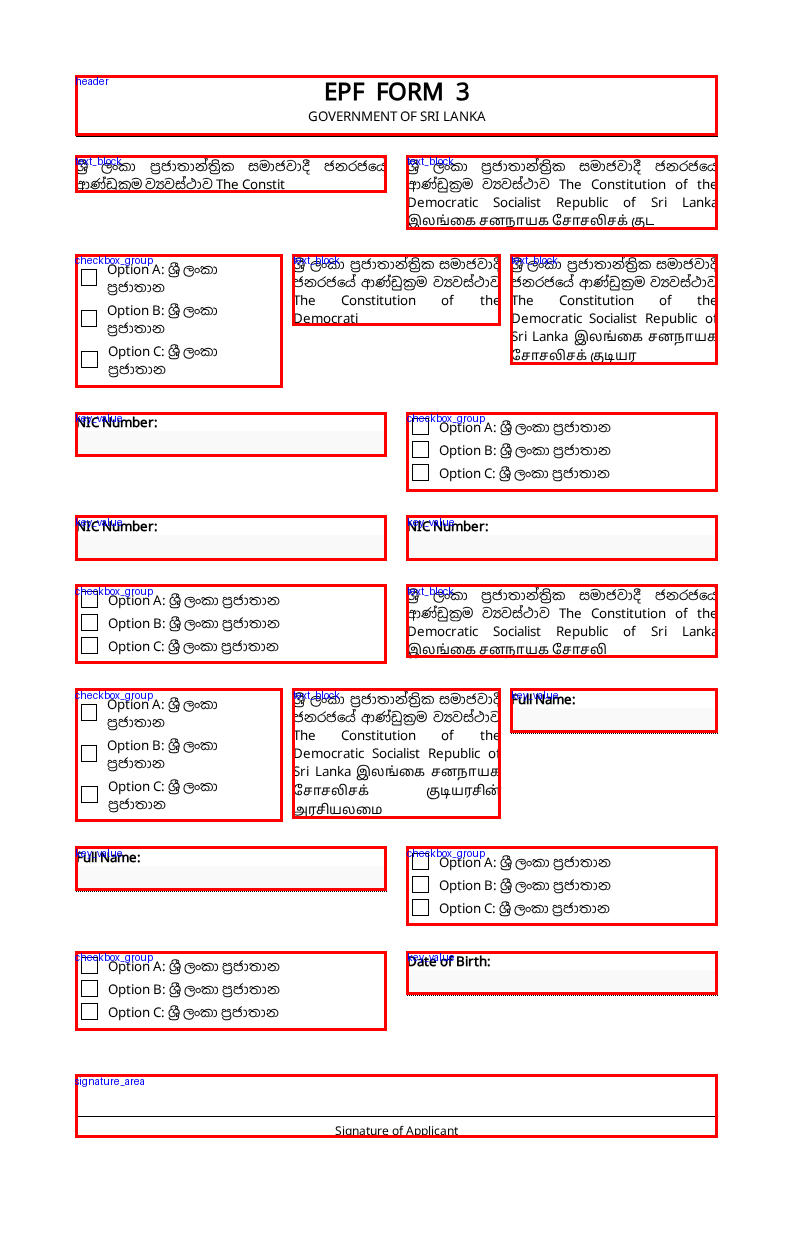

In [6]:
import random
from PIL import ImageDraw

# Load a random sample from the training set
sample = dataset_split["train"][random.randint(0, len(dataset_split["train"])-1)]
image = sample["image"]
bboxes = sample["bboxes"]
tags = sample["ner_tags"]

draw = ImageDraw.Draw(image)
width, height = image.size

# Draw boxes
for box, tag in zip(bboxes, tags):
    # Denormalize (1000 scale -> pixels) for drawing
    x1 = (box[0] / 1000) * width
    y1 = (box[1] / 1000) * height
    x2 = (box[2] / 1000) * width
    y2 = (box[3] / 1000) * height

    # Draw Red Box
    draw.rectangle([x1, y1, x2, y2], outline="red", width=3)
    # Draw Label
    draw.text((x1, y1), id2label[tag], fill="blue")

# Show
display(image) # Colab command

# Change in Mind
YOLOv8 instead of LayoutLMv3
dataset contains Bounding Boxes and Class Labels, but it does not contain the actual Text Content (tokens) inside those boxes. Yes the image clearly has text in it, but those text was just generated and our json file doesn't include them it only contains the bounding boxes so yeah.

The Problem: LayoutLMv3 is a multimodal model. It needs the text (e.g., "Name:") to work its magic. If we feed it empty text, it becomes a very slow, heavy image classifier.

The Solution: YOLOv8 (You Only Look Once). It looks at the shape of a paragraph or table (just like a how we squinting at a page) and detects it instantly. It is 10x faster than LayoutLMv3 and doesn't need text inputs.

In [7]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 31.1 MB/s eta 0:00:00


### Convert Dataset to YOLO Format

YOLO is strict. It doesn't want JSON or Hugging Face datasets. It wants this specific folder structure:

In [8]:
import os
import json
import shutil
import random
from pathlib import Path
from PIL import Image
import yaml

# CONFIG
SOURCE_DIR = Path("dataset_complex")
OUTPUT_DIR = Path("yolo_dataset")

# Define Class Mapping (Must match the generator!)
# YOLO needs class IDs starting at 0
class_map = {
    "header": 0,
    "text_block": 1,
    "paragraph": 1,       # Handle alias
    "key_value": 2,
    "key_value_pair": 2,  # Handle alias
    "checkbox_group": 3,
    "table": 4,
    "signature_area": 5,
    "signature": 5        # Handle alias
}

def convert_to_yolo_bbox(bbox, w, h):
    # Input: [x, y, width, height] (Pixels)
    # Output: [x_center, y_center, width, height] (Normalized 0-1)

    x, y, box_w, box_h = bbox

    dw = 1.0 / w
    dh = 1.0 / h

    x_center = x + box_w / 2.0
    y_center = y + box_h / 2.0

    x_center *= dw
    width_norm = box_w * dw
    y_center *= dh
    height_norm = box_h * dh

    return [x_center, y_center, width_norm, height_norm]

def create_yolo_dataset():
    # 1. Setup Folders
    for split in ["train", "val"]:
        (OUTPUT_DIR / split / "images").mkdir(parents=True, exist_ok=True)
        (OUTPUT_DIR / split / "labels").mkdir(parents=True, exist_ok=True)

    # 2. List Files
    json_files = sorted(list((SOURCE_DIR / "labels").glob("*.json")))
    random.shuffle(json_files)

    # Split 80/20
    split_idx = int(len(json_files) * 0.8)
    train_files = json_files[:split_idx]
    val_files = json_files[split_idx:]

    print(f"Converting {len(train_files)} training and {len(val_files)} validation samples...")

    def process_files(file_list, split):
        for json_file in file_list:
            # Load Label
            with open(json_file, "r") as f:
                data = json.load(f)

            # Find Image
            img_name = data["file"]
            src_img_path = SOURCE_DIR / "images" / img_name

            if not src_img_path.exists():
                continue

            # Load Image size
            with Image.open(src_img_path) as img:
                img_w, img_h = img.size

            # Prepare Label Text
            yolo_lines = []
            for item in data["annotations"]:
                cls_name = item["class"]
                if cls_name not in class_map:
                    continue

                cls_id = class_map[cls_name]
                bbox = item["bbox_px"]

                # Convert
                yolo_bbox = convert_to_yolo_bbox([bbox[0], bbox[1], bbox[2], bbox[3]], img_w, img_h)

                # Format: class x_c y_c w h
                line = f"{cls_id} {' '.join([f'{x:.6f}' for x in yolo_bbox])}"
                yolo_lines.append(line)

            # WRITE FILES
            # 1. Copy Image
            shutil.copy(src_img_path, OUTPUT_DIR / split / "images" / img_name)

            # 2. Write Label
            txt_name = Path(img_name).stem + ".txt"
            with open(OUTPUT_DIR / split / "labels" / txt_name, "w") as f:
                f.write("\n".join(yolo_lines))

    process_files(train_files, "train")
    process_files(val_files, "val")

    # 3. Create dataset.yaml (Configuration file for YOLO)
    yaml_content = f"""
    path: {OUTPUT_DIR.resolve()}
    train: train/images
    val: val/images

    names:
      0: header
      1: text_block
      2: key_value
      3: checkbox_group
      4: table
      5: signature_area
    """

    with open(OUTPUT_DIR / "dataset.yaml", "w") as f:
        f.write(yaml_content)

    print("Success! YOLO dataset ready at:", OUTPUT_DIR)

create_yolo_dataset()

Converting 800 training and 200 validation samples...
Success! YOLO dataset ready at: yolo_dataset


In [9]:
!cp -r /content/synthetic-data-generator/yolo_dataset /content/drive/MyDrive/

### Train the Model

In [10]:
from ultralytics import YOLO

# 1. Load Pre-trained Model
# 'yolov8n.pt' is the smallest model. ()'yolov8s.pt' or 'yolov8m.pt' for higher accuracy but takes time.)
model = YOLO('yolov8n.pt')

# 2. Train
results = model.train(
    data='yolo_dataset/dataset.yaml',
    epochs=20, # 20 epochs is usually plenty for synthetic data
    imgsz=640, # Image size
    batch=16,
    name='sinhala_doc_layout'# Name of the output project
)

print("Training Complete!")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.252 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=yolo_dataset/dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fals

In [13]:
!cp -r /content/synthetic-data-generator/runs /content/drive/MyDrive/

### Results

In [12]:
import glob
from IPython.display import Image, display

# Run inference on a random validation image
val_images = glob.glob("yolo_dataset/val/images/*.png")
test_img = val_images[0]

# Predict
results = model.predict(test_img, save=True, conf=0.5)


image 1/1 /content/synthetic-data-generator/yolo_dataset/val/images/complex_sample_0741.png: 640x480 1 header, 2 text_blocks, 7 key_values, 3 checkbox_groups, 1 signature_area, 11.3ms
Speed: 3.9ms preprocess, 11.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 480)
Results saved to /content/synthetic-data-generator/runs/detect/predict2
Check the runs/detect folder manually.


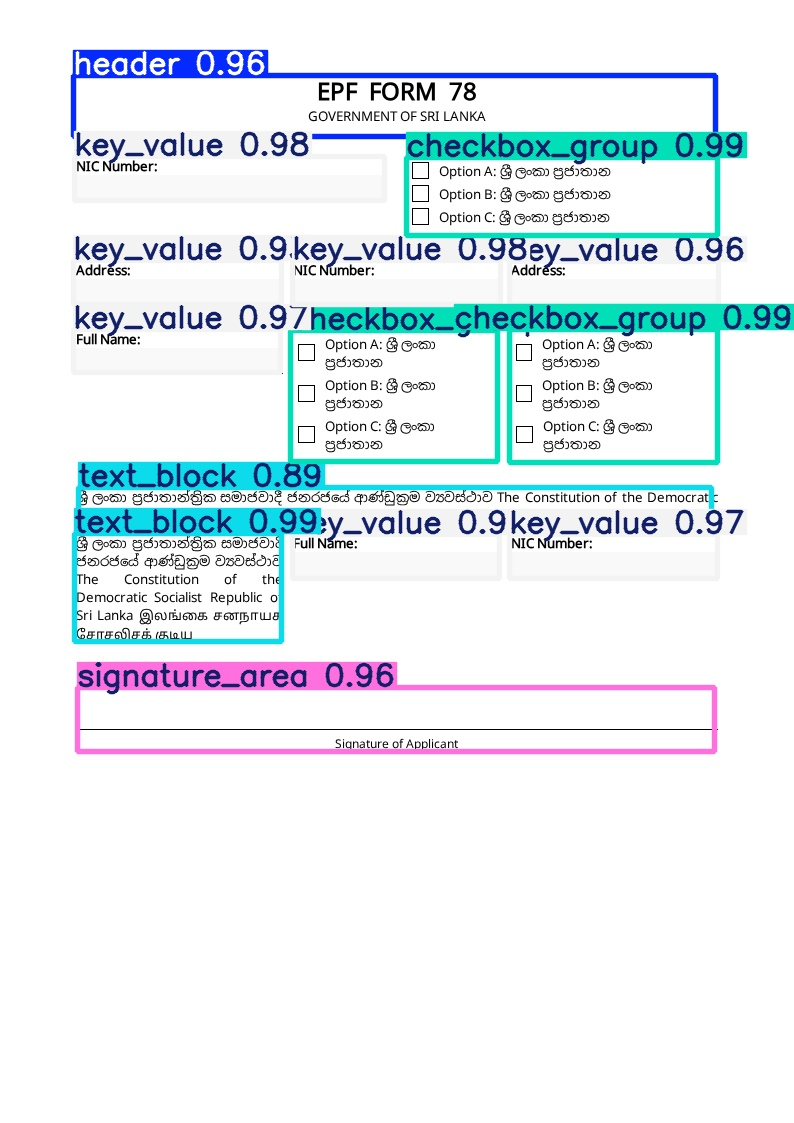

In [16]:
# Show Result
# YOLO saves results in 'runs/detect/sinhala_doc_layout/predict/'
saved_files = glob.glob("runs/detect/predict2/*.jpg") # Find the latest output
display(Image(filename=saved_files[0]))


# Paddle OCR

In [2]:

# Install the OCR toolkit
!pip install paddleocr

In [1]:
# Uninstall any existing CPU version just in case
!pip uninstall -y paddlepaddle paddlepaddle-gpu

# Install GPU version (Auto-detects CUDA 11/12 on Colab)
!pip install paddlepaddle-gpu
!pip install paddleocr ultralytics

Found existing installation: paddlepaddle-gpu 2.6.2
Uninstalling paddlepaddle-gpu-2.6.2:
  Successfully uninstalled paddlepaddle-gpu-2.6.2
  Using cached paddlepaddle_gpu-2.6.2-cp312-cp312-manylinux1_x86_64.whl.metadata (8.6 kB)
Using cached paddlepaddle_gpu-2.6.2-cp312-cp312-manylinux1_x86_64.whl (758.9 MB)


In [3]:
!pip install langchain langchain-community

In [4]:
!pip install -U langchain-community langchain-core langchain-text-splitters


In [5]:
from paddleocr import PaddleOCR
from PIL import Image
from ultralytics import YOLO
import numpy as np
import time

# --- 1. INITIALIZE ON GPU ---
# use_gpu=True : CRITICAL for T4 speed
# use_angle_cls=True : Rotates skewed text
# lang='sin' : Optimized for Sinhala/English mix
print("Loading PaddleOCR on GPU...")
ocr_engine = PaddleOCR(use_angle_cls=True, lang='sin', use_gpu=True, show_log=False)

def run_fast_extraction(image_path, model_path='runs/detect/sinhala_doc_layout/weights/best.pt'):
    # Load YOLO Model (also on GPU automatically)
    layout_model = YOLO(model_path)

    start_time = time.time()

    # 1. Layout Inference
    results = layout_model.predict(image_path)
    result = results[0]

    original_img = Image.open(image_path).convert("RGB")
    extracted_data = []

    print(f"\nProcessing {image_path} with T4 GPU...")

    # 2. Iterate and Extract
    for box in result.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
        class_id = int(box.cls[0])
        class_name = result.names[class_id]
        confidence = float(box.conf[0])

        # Crop
        crop = original_img.crop((x1, y1, x2, y2))

        content = ""

        if class_name in ["header", "text_block", "key_value"]:
            # Convert to Numpy for Paddle
            img_array = np.array(crop)

            # Run OCR (Lightning fast on GPU)
            ocr_result = ocr_engine.ocr(img_array, cls=True)

            if ocr_result and ocr_result[0]:
                content = " ".join([line[1][0] for line in ocr_result[0]])
            else:
                content = ""

        elif class_name == "checkbox_group":
            # For checkboxes, we might want to OCR the label next to it
            img_array = np.array(crop)
            ocr_result = ocr_engine.ocr(img_array, cls=True)
            if ocr_result and ocr_result[0]:
                 content = "[Options]: " + " ".join([line[1][0] for line in ocr_result[0]])

        elif class_name == "signature_area":
            content = "[Signature Image Captured]"

        # Add to JSON
        extracted_data.append({
            "type": class_name,
            "bbox": [x1, y1, x2, y2],
            "text": content,
            "conf": round(confidence, 2)
        })

    total_time = time.time() - start_time
    print(f"✅ Finished in {total_time:.2f} seconds.")

    return extracted_data

# --- TEST IT ---
# Upload your 'complex_sample_0741.jpg' to Colab files first!
data = run_fast_extraction('complex_sample_0741.jpg')

# Print Result
import json
print(json.dumps(data, indent=2, ensure_ascii=False))

Checking connectivity to the model hosters, this may take a while. To bypass this check, set `DISABLE_MODEL_SOURCE_CHECK` to `True`.


ModuleNotFoundError: No module named 'langchain.docstore'